# Looping over systematic models

Ideally, we would be using something from this in the docs to loop through our 50 different systematic models, which only differ in which parameters are thawed or frozen:  
https://sherpa.readthedocs.io/en/4.11.0/model_classes/api/sherpa.models.model.SimulFitModel.html#sherpa.models.model.SimulFitModel

Until such time that we understand how that works, we will be helping ourselves with a good old `for` loop. In this notebook, I am figuring out how.

In [2]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import G

os.chdir('../')
from config import CONFIG_INI
from limb_darkening import limb_dark_fit
import margmodule as marg

from sherpa.data import Data1D
from sherpa.plot import DataPlot
from sherpa.plot import ModelPlot
from sherpa.fit import Fit
from sherpa.stats import LeastSq
from sherpa.optmethods import LevMar
from sherpa.stats import Chi2
from sherpa.plot import FitPlot

### Data paths

In [3]:
localDir = CONFIG_INI.get('data_paths', 'local_path')
outDir = os.path.join(localDir, CONFIG_INI.get('data_paths', 'output_path'))
curr_model = CONFIG_INI.get('data_paths', 'current_model')
dataDir = os.path.join(localDir, os.path.join(localDir, CONFIG_INI.get('data_paths', 'data_path')), curr_model)

### Read data

In [4]:
# Read in the txt file for the lightcurve data
x, y, err, sh = np.loadtxt(os.path.join(dataDir, 'W17_white_lightcurve_test_data.txt'), skiprows=7, unpack=True)
wavelength = np.loadtxt(os.path.join(dataDir, 'W17_wavelength_test_data.txt'), skiprows=3)

tzero = x[0]
flux0 = y[0]

print("x.shape: {}".format(x.shape))
print("y.shape: {}".format(y.shape))
print("err.shape: {}".format(err.shape))
print("sh.shape: {}".format(sh.shape))
print("wvln.shape: {}".format(wavelength.shape))

x.shape: (51,)
y.shape: (51,)
err.shape: (51,)
sh.shape: (51,)
wvln.shape: (115,)


### PLanet parameters and limb darkening

In [6]:
Per = CONFIG_INI.getfloat('planet_parameters', 'Per') * u.d
Per = Per.to(u.s)
constant1 = ((G * np.square(Per)) / (4 * np.square(np.pi))) ** (1 / 3)
aor = CONFIG_INI.getfloat('planet_parameters', 'aor')    # this is unitless -> "distance of the planet from the star (meters)/stellar radius (meters)"
MsMpR = (aor / constant1) ** 3.
print("MsMpR: {}\n".format(MsMpR))

# Limb darkening
M_H = CONFIG_INI.getfloat('limb_darkening', 'metallicity')    # metallicity
Teff = CONFIG_INI.getfloat('limb_darkening', 'Teff')   # effective temperature
logg = CONFIG_INI.getfloat('limb_darkening', 'logg')   # log(g), gravitation

# Define limb darkening directory, which is inside this package
limbDir = os.path.join('..', 'Limb-darkening')
ld_model = CONFIG_INI.get('limb_darkening', 'ld_model')
grat = CONFIG_INI.get('technical_parameters', 'grating')
_uLD, c1, c2, c3, c4, _cp1, _cp2, _cp3, _cp4, _aLD, _bLD = limb_dark_fit(grat, wavelength, M_H,
                                                                         Teff, logg, limbDir, ld_model)
print("\nThe four cs: {}, {}, {}, {}".format(c1, c2, c3, c4))

MsMpR: 2013.6545130315214 kg / m3

You are using the 3D limb darkening models.
Current Directories Entered:
  ../Limb-darkening
  ../Limb-darkening/3DGrid
Filename: mmu_t65g45m10v05.flx

Closest values to your inputs:
Teff:  6500
M_H:  -1.0
log(g):  4.5

Limb darkening parameters:
4param 	0.87943740	-0.75690632	0.56316819	-0.17285109
3param 	2.18170435	-3.13702297	1.39277902
Quad 	0.03258950	0.35826185
Linear 	0.33642864

The four cs: 0.8794374046913269, -0.7569063175194662, 0.5631681864067452, -0.17285109276089056


### Sherpa data object

name      = Data
x         = Float64[51]
y         = Float64[51]
staterror = Float64[51]
syserror  = None


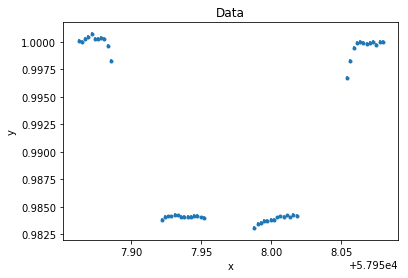

In [8]:
# Instantiate a data object
data = Data1D('Data', x, y, staterror=err)
print(data)

# Plot the data with Sherpa
dplot = DataPlot()
dplot.prepare(data)
dplot.plot() 

### Sherpa model - here's where we start working

All parameters will be thawed, except for the ones that have `alwaysfrozen=True` in their initializaiton.

In [9]:
# Define the model
tmodel = marg.Transit(tzero, MsMpR, c1, c2, c3, c4, flux0, name="testmodel", sh=sh)
print(tmodel)

testmodel
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   testmodel.rl thawed     0.121692 -3.40282e+38  3.40282e+38           
   testmodel.flux thawed      1.00007 -3.40282e+38  3.40282e+38           
   testmodel.epoch thawed        57958 -3.40282e+38  3.40282e+38 days [MJD]
   testmodel.inclin thawed      1.52448 -3.40282e+38  3.40282e+38    radians
   testmodel.msmpr thawed      2013.65 -3.40282e+38  3.40282e+38           
   testmodel.ecc thawed            0 -3.40282e+38  3.40282e+38    degrees
   testmodel.omega frozen            0 -3.40282e+38  3.40282e+38    degrees
   testmodel.period frozen      3.73549 -3.40282e+38  3.40282e+38       days
   testmodel.tzero frozen      57957.9 -3.40282e+38  3.40282e+38 days [MJD]
   testmodel.c1 frozen     0.879437 -3.40282e+38  3.40282e+38           
   testmodel.c2 frozen    -0.756906 -3.40282e+38  3.40282e+38           
   testmodel.c3 fr

We can read the requested grid from our module.

In [12]:
grid_selection = CONFIG_INI.get('technical_parameters', 'grid_selection')
grid = marg.wfc3_systematic_model_grid_selection(grid_selection)
print('1st systematic model: {}'.format(grid[0]))

1st systematic model: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


We can loop through that easily.

In [14]:
for i, s in enumerate(grid):
    print(i+1, s)

1 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
2 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1]
3 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1]
4 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1]
5 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]
6 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
7 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1]
8 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1]
9 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1]
10 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0]
11 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1]
12 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1]
13 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1]
14 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 1]
15 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0]
16 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1]
17 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1]
18 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1]
19 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1]
20 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0]
21 [0 0 0 1 1 1 1 1 1 1 1 1 1

So, `s` will be a single systematic model:

In [15]:
print(s)

[0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]


So far, so good.

Now, we can also loop though all the model parameters pretty easily.

In [22]:
for i in tmodel.pars:
    print('->', i.name)
    print(i)
    print('\n')

-> rl
val         = 0.12169232
min         = -3.4028234663852886e+38
max         = 3.4028234663852886e+38
units       = 
frozen      = False
link        = None
default_val = 0.12169232
default_min = -3.4028234663852886e+38
default_max = 3.4028234663852886e+38


-> flux
val         = 1.00006655
min         = -3.4028234663852886e+38
max         = 3.4028234663852886e+38
units       = 
frozen      = False
link        = None
default_val = 1.00006655
default_min = -3.4028234663852886e+38
default_max = 3.4028234663852886e+38


-> epoch
val         = 57957.97015339
min         = -3.4028234663852886e+38
max         = 3.4028234663852886e+38
units       = days [MJD]
frozen      = False
link        = None
default_val = 57957.97015339
default_min = -3.4028234663852886e+38
default_max = 3.4028234663852886e+38


-> inclin
val         = 1.5244813970993492
min         = -3.4028234663852886e+38
max         = 3.4028234663852886e+38
units       = radians
frozen      = False
link        = None
default_val 

Now we need to think of a way to combine `s` with the parameters in the model. Remember that `s` has as many entries as `tmodel` has parameters.

In [25]:
# The first loop is the big loop that goes through all the systematic models.
# The second loop is what sets up the frozen and thawed parameters.
for i, s in enumerate(grid):
    for k, p in enumerate(s):
        print('i:', i)
        print('k:', p)

i: 0
k: 0
i: 0
k: 0
i: 0
k: 0
i: 0
k: 1
i: 0
k: 1
i: 0
k: 1
i: 0
k: 1
i: 0
k: 1
i: 0
k: 1
i: 0
k: 1
i: 0
k: 1
i: 0
k: 1
i: 0
k: 1
i: 0
k: 1
i: 0
k: 1
i: 0
k: 1
i: 0
k: 1
i: 0
k: 1
i: 0
k: 1
i: 0
k: 1
i: 0
k: 1
i: 0
k: 1
i: 1
k: 0
i: 1
k: 0
i: 1
k: 0
i: 1
k: 1
i: 1
k: 1
i: 1
k: 1
i: 1
k: 1
i: 1
k: 1
i: 1
k: 1
i: 1
k: 1
i: 1
k: 1
i: 1
k: 1
i: 1
k: 1
i: 1
k: 1
i: 1
k: 1
i: 1
k: 1
i: 1
k: 1
i: 1
k: 1
i: 1
k: 0
i: 1
k: 1
i: 1
k: 1
i: 1
k: 1
i: 2
k: 0
i: 2
k: 0
i: 2
k: 0
i: 2
k: 1
i: 2
k: 1
i: 2
k: 1
i: 2
k: 1
i: 2
k: 1
i: 2
k: 1
i: 2
k: 1
i: 2
k: 1
i: 2
k: 1
i: 2
k: 1
i: 2
k: 1
i: 2
k: 1
i: 2
k: 1
i: 2
k: 1
i: 2
k: 1
i: 2
k: 0
i: 2
k: 0
i: 2
k: 1
i: 2
k: 1
i: 3
k: 0
i: 3
k: 0
i: 3
k: 0
i: 3
k: 1
i: 3
k: 1
i: 3
k: 1
i: 3
k: 1
i: 3
k: 1
i: 3
k: 1
i: 3
k: 1
i: 3
k: 1
i: 3
k: 1
i: 3
k: 1
i: 3
k: 1
i: 3
k: 1
i: 3
k: 1
i: 3
k: 1
i: 3
k: 1
i: 3
k: 0
i: 3
k: 0
i: 3
k: 0
i: 3
k: 1
i: 4
k: 0
i: 4
k: 0
i: 4
k: 0
i: 4
k: 1
i: 4
k: 1
i: 4
k: 1
i: 4
k: 1
i: 4
k: 1
i: 4
k: 1
i: 4
k: 1
i: 4
k: 1
i: 4
k: 1


In [26]:
# Now in our context with the model:

In [38]:
for i, s in enumerate(grid):
    #print(s)
    for k, select in enumerate(s):
        if select == 0:
            tmodel.pars[k].thaw()
        elif select == 1:
            tmodel.pars[k].freeze()

How do we test this though? Lets do it one by one with the systematics.

In [36]:
po = 36  # pick any between 0 and 49 (we have 50 systematic models)
sys = grid[po]
print(sys)

for k, select in enumerate(sys):
    if select == 0:
        tmodel.pars[k].thaw()
    elif select == 1:
        tmodel.pars[k].freeze()

print(tmodel)

[0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1]
testmodel
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   testmodel.rl thawed     0.121692 -3.40282e+38  3.40282e+38           
   testmodel.flux thawed      1.00007 -3.40282e+38  3.40282e+38           
   testmodel.epoch thawed        57958 -3.40282e+38  3.40282e+38 days [MJD]
   testmodel.inclin frozen      1.52448 -3.40282e+38  3.40282e+38    radians
   testmodel.msmpr frozen      2013.65 -3.40282e+38  3.40282e+38           
   testmodel.ecc frozen            0 -3.40282e+38  3.40282e+38    degrees
   testmodel.omega frozen            0 -3.40282e+38  3.40282e+38    degrees
   testmodel.period frozen      3.73549 -3.40282e+38  3.40282e+38       days
   testmodel.tzero frozen      57957.9 -3.40282e+38  3.40282e+38 days [MJD]
   testmodel.c1 frozen     0.879437 -3.40282e+38  3.40282e+38           
   testmodel.c2 frozen    -0.756906 -3.40282e

Works!